In [23]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import datetime as dt
import mplfinance as mpf
import time 
import os
from os import listdir
from os.path import isfile, join
import statsmodels.api as sm
import seaborn as sns

In [24]:
Path='C:\\Users\\nafissaad\\Finance\\Stock List\\'
s_year = 2017
s_month = 1
s_day = 3
s_date_str = '2017-01-03'
s_date_datetime = dt.datetime(s_year,s_month,s_day)
e_year = 2021
e_month = 8
e_day = 19
e_date_str = '2021-08-19'
e_date_datetime = dt.datetime(e_year,e_month,e_day)

In [25]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(Path + ticker + '.csv',index_col='Date',parse_dates=True)
    except FileNotFoundError:
        pass
    else:
        return df

In [26]:
a_df = get_df_from_csv('GOOG')
a_df = a_df.asfreq('D')
a_df = a_df.fillna(method='ffill')

In [27]:
a_df= a_df.drop(['daily_return'], axis =1)
len(a_df)

1849

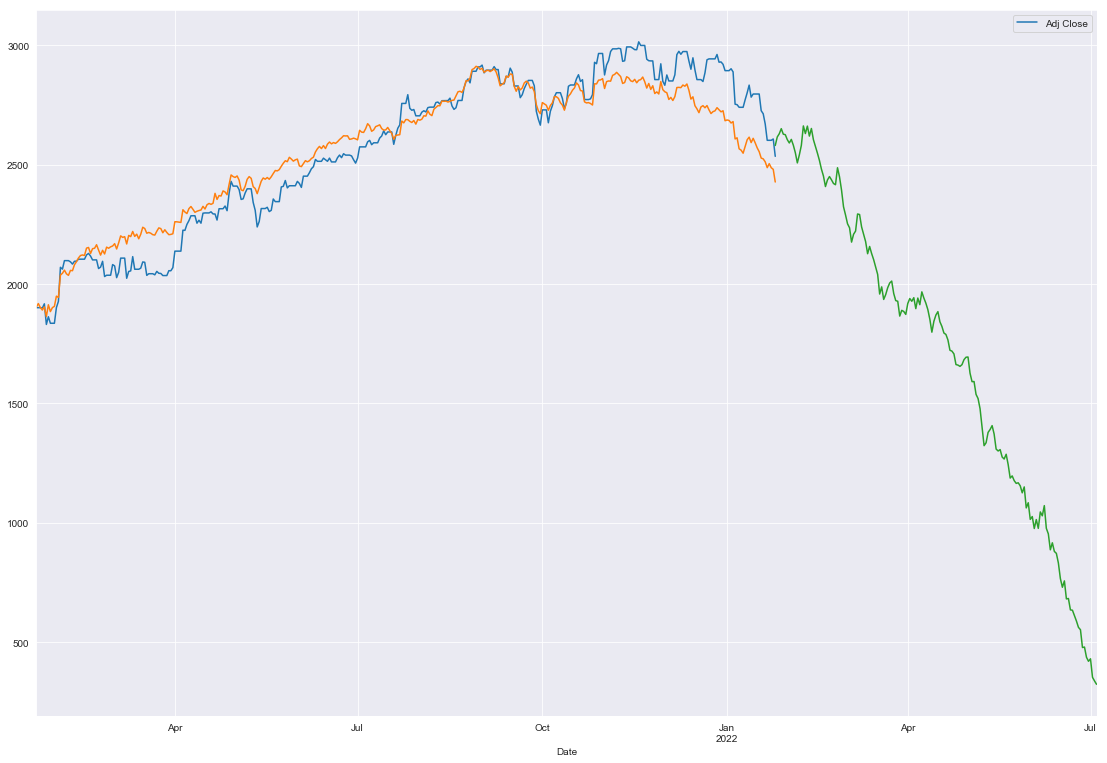

In [32]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(19,13))
fig,ax = plt.subplots()
lags=ar_select_order(a_df,maxlag=30)
model = AutoReg(a_df['Adj Close'],lags.ar_lags)
model_fit = model.fit()
train_df =a_df.iloc[:1480]
test_df = a_df.iloc[1480:]
train_model = AutoReg(a_df['Adj Close'], 600).fit(cov_type="HC0")#900 sample data
start=len(train_df)
end = len(train_df)+len(test_df)-1
prediction = train_model.predict(start=start,end=end,dynamic= True)
ax = test_df.plot(ax=ax)
ax = prediction.plot(ax=ax)
forecast = train_model.predict(start=end, end=end+160,dynamic=True)
ax = forecast.plot(ax=ax)

In [33]:
len(a_df)

1849

In [34]:
1849*0.80

1479.2

In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

In [36]:
STL=STL(a_df['Adj Close'])
Result=STL.fit()

In [37]:
seasonal,trend,resid = Result.seasonal,Result.trend, Result.resid

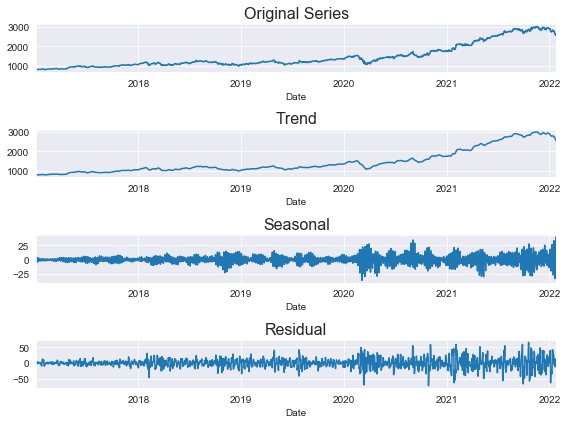

In [38]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
a_df['Adj Close'].plot()
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
trend.plot()
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
seasonal.plot()
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
resid.plot()
plt.title('Residual', fontsize=16)

plt.tight_layout()

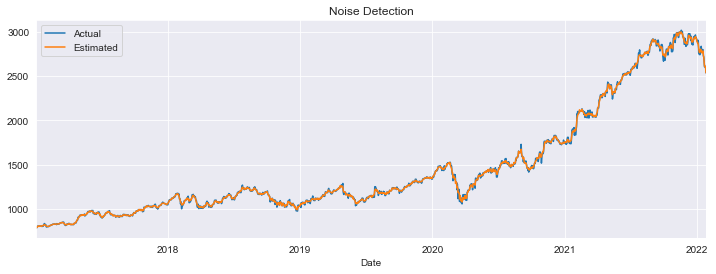

In [39]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
a_df['Adj Close'].plot(label='Actual')
estimated.plot(label='Estimated')
plt.title('Noise Detection')
plt.legend()
plt.show()

In [40]:
def adfuller_test(sales):
    result= adfuller(sales)
    labels = ["ADF Test Statistics","p-value","#Lags Used","Number of Observations Used"]
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [41]:
first_diff =estimated.diff()[1:]

In [42]:
first_diff=first_diff.fillna(0)

In [43]:
adfuller_test(first_diff)

ADF Test Statistics : -6.576907180055866
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
p-value : 7.684794710307348e-09
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
#Lags Used : 25
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
Number of Observations Used : 1822
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


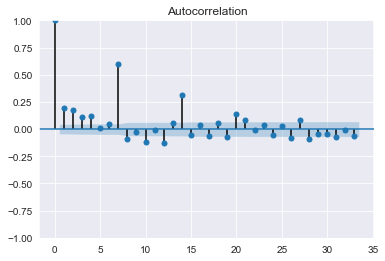

In [44]:
acf_plot = plot_acf(first_diff)

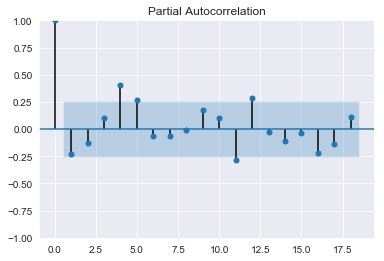

In [17]:
pacf_plot = plot_pacf(first_diff,method='ywm')

In [45]:
from statsmodels.tsa.arima.model import ARIMA
my_order=(7,1,7)# My time series is seasonal thats why i am setting my normal AR,MA=0, and 1 differencing helped me get my time series stationary
model = ARIMA(estimated, order=my_order)

In [46]:
model_fit = model.fit()

C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [47]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1849
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -5826.846
Date:                Wed, 02 Feb 2022   AIC                          11683.691
Time:                        11:31:57   BIC                          11766.519
Sample:                    01-03-2017   HQIC                         11714.226
                         - 01-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1408      0.018     -7.847      0.000      -0.176      -0.106
ar.L2         -0.0866      0.019     -4.574      0.000      -0.124      -0.049
ar.L3         -0.1685      0.020     -8.262      0.0

In [49]:
predictions = model_fit.forecast(10)
predictions

2022-01-26    2521.125505
2022-01-27    2469.052495
2022-01-28    2436.152164
2022-01-29    2437.834460
2022-01-30    2447.733764
2022-01-31    2458.839756
2022-02-01    2408.002423
2022-02-02    2410.012613
2022-02-03    2379.563807
2022-02-04    2369.216616
Freq: D, Name: predicted_mean, dtype: float64

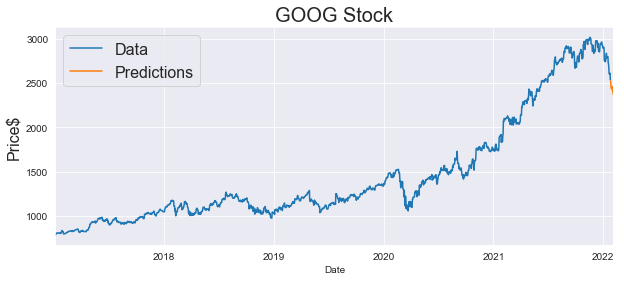

In [51]:
plt.figure(figsize=(10,4))

a_df['Adj Close'].plot()
predictions.plot()

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('GOOG Stock', fontsize=20)
plt.ylabel('Price$', fontsize=16)

for year in range(1,5):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
plt.show()


In [60]:
train_data=estimated[:-20]
test_data=estimated[-20:]

In [61]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = estimated[:train_end-timedelta(days=1)]
    model = ARIMA(train_data, order=my_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
print(rolling_predictions)

C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

Date
2022-01-06    2797.074370
2022-01-07    2764.613205
2022-01-08    2746.454328
2022-01-09    2762.635305
2022-01-10    2795.371166
2022-01-11    2801.486632
2022-01-12    2786.568896
2022-01-13    2772.704149
2022-01-14    2763.843273
2022-01-15    2767.337644
2022-01-16    2779.211743
2022-01-17    2787.293288
2022-01-18    2758.987930
2022-01-19    2711.134969
2022-01-20    2677.153259
2022-01-21    2625.647844
2022-01-22    2597.461805
2022-01-23    2603.635002
2022-01-24    2608.468699
2022-01-25    2563.573656
Freq: D, dtype: float64


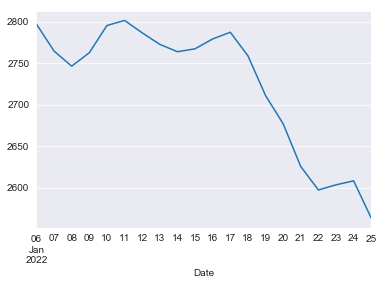

In [71]:
rolling_predictions.plot()
plt.show()

In [81]:
from scipy.signal import savgol_filter
yhat = savgol_filter(rolling_predictions, 3, 1)
yhat

array([2794.6906551 , 2769.38063448, 2757.90094617, 2768.15359976,
       2786.49770109, 2794.47556473, 2786.91989233, 2774.3721057 ,
       2767.96168856, 2770.13088674, 2777.94755854, 2775.16432051,
       2752.47206244, 2715.75871949, 2671.31202418, 2633.42096942,
       2608.91488369, 2603.18850209, 2591.89245247, 2571.86177957])

In [82]:
rng = pd.date_range(start="2022-01-06",end="2022-01-25",freq='D')
rolling_predictions1 = pd.Series(yhat, index=rng)
rolling_predictions1

2022-01-06    2794.690655
2022-01-07    2769.380634
2022-01-08    2757.900946
2022-01-09    2768.153600
2022-01-10    2786.497701
2022-01-11    2794.475565
2022-01-12    2786.919892
2022-01-13    2774.372106
2022-01-14    2767.961689
2022-01-15    2770.130887
2022-01-16    2777.947559
2022-01-17    2775.164321
2022-01-18    2752.472062
2022-01-19    2715.758719
2022-01-20    2671.312024
2022-01-21    2633.420969
2022-01-22    2608.914884
2022-01-23    2603.188502
2022-01-24    2591.892452
2022-01-25    2571.861780
Freq: D, dtype: float64

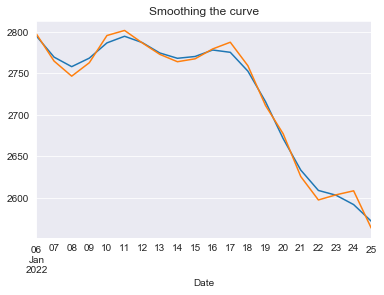

In [83]:
rolling_predictions1.plot()
rolling_predictions.plot()
plt.title('Smoothing the curve')
plt.show()

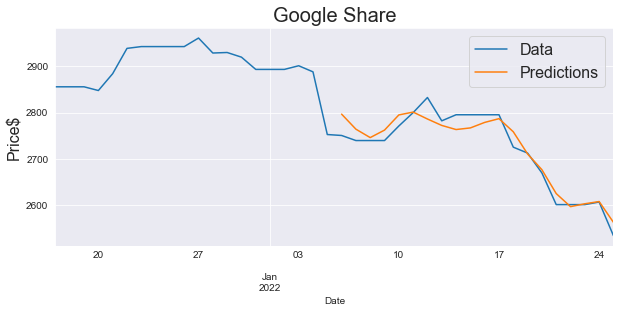

In [87]:
plt.figure(figsize=(10,4))

a_df['Adj Close'][-40:].plot()
rolling_predictions.plot()

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Google Share', fontsize=20)
plt.ylabel('Price$', fontsize=16)
plt.show()

In [88]:
a_df['Adj Close'][-20:]

Date
2022-01-06    2751.020020
2022-01-07    2740.090088
2022-01-08    2740.090088
2022-01-09    2740.090088
2022-01-10    2771.479980
2022-01-11    2800.350098
2022-01-12    2832.959961
2022-01-13    2782.620117
2022-01-14    2795.729980
2022-01-15    2795.729980
2022-01-16    2795.729980
2022-01-17    2795.729980
2022-01-18    2725.810059
2022-01-19    2713.040039
2022-01-20    2670.129883
2022-01-21    2601.840088
2022-01-22    2601.840088
2022-01-23    2601.840088
2022-01-24    2607.439941
2022-01-25    2534.709961
Freq: D, Name: Adj Close, dtype: float64

In [89]:
rolling_predictions1

2022-01-06    2794.690655
2022-01-07    2769.380634
2022-01-08    2757.900946
2022-01-09    2768.153600
2022-01-10    2786.497701
2022-01-11    2794.475565
2022-01-12    2786.919892
2022-01-13    2774.372106
2022-01-14    2767.961689
2022-01-15    2770.130887
2022-01-16    2777.947559
2022-01-17    2775.164321
2022-01-18    2752.472062
2022-01-19    2715.758719
2022-01-20    2671.312024
2022-01-21    2633.420969
2022-01-22    2608.914884
2022-01-23    2603.188502
2022-01-24    2591.892452
2022-01-25    2571.861780
Freq: D, dtype: float64